# Airbnb Dynamic Pricing Dataset Builder

This notebook rebuilds the listings dataset from raw Airbnb JSON exports, engineers pricing features that stay close to the source of truth, and delivers transparent exploratory analysis so the dynamic pricing service can target an 8–15% yield lift for hosts.

## 2. Load Raw Airbnb JSON Dumps

We iterate over every JSON export in `data/raw`, streaming items lazily (using `ijson` when available) so even season-wide dumps can be ingested without exhausting memory.

In [5]:
RAW_DIR = ROOT / "data" / "raw"
RAW_JSON_FILES = sorted(RAW_DIR.rglob("*.json"))
print(f"Discovered {len(RAW_JSON_FILES)} raw dumps")

DATE_PATTERN = re.compile(r"\d{4}-\d{2}-\d{2}")
NIGHT_PATTERN = re.compile(r"(\d+)\s+nights?", re.IGNORECASE)
PRICE_PATTERN = re.compile(r"([0-9]+(?:[.,][0-9]+)?)")


def parse_date_token(token: Optional[str]) -> Optional[pd.Timestamp]:
    if not token:
        return None
    match = DATE_PATTERN.search(token)
    return pd.to_datetime(match.group(0)) if match else pd.to_datetime(token, errors="coerce")


def infer_file_metadata(path: Path) -> Dict[str, Optional[str]]:
    tokens = path.stem.split("_")
    city = tokens[0].lower()
    start_hint = tokens[1] if len(tokens) >= 2 else None
    end_hint = tokens[2] if len(tokens) >= 3 else None
    return {
        "city": city,
        "season": path.parent.name,
        "start_date_hint": start_hint,
        "end_date_hint": end_hint,
    }


def stream_json(path: Path) -> Iterator[dict]:
    if ijson is not None:
        with path.open("r", encoding="utf-8") as fh:
            yield from ijson.items(fh, "item")
    else:
        with path.open("r", encoding="utf-8") as fh:
            data = json.load(fh)
        for item in data:
            yield item


def load_raw_records(paths: Iterable[Path]) -> List[dict]:
    buffer: List[dict] = []
    for fp in paths:
        meta = infer_file_metadata(fp)
        for listing in stream_json(fp):
            listing["__meta"] = {
                **meta,
                "source_file": str(fp.relative_to(ROOT)),
            }
            buffer.append(listing)
    return buffer


raw_listings = load_raw_records(RAW_JSON_FILES)
total_records = len(raw_listings)
print(f"Loaded {total_records} listing snapshots")

raw_overview = (
    pd.DataFrame([rec["__meta"] for rec in raw_listings])
    .value_counts(["city", "season"], sort=False)
    .rename("listings")
    .reset_index()
)
raw_overview

Discovered 19 raw dumps


Loaded 5011 listing snapshots


,city,season,listings
0,agadir,april,280
1,agadir,march,280
2,agadir,summer,280
3,casablanca,april,280
4,casablanca,march,280
5,casablanca,raw,280
6,casablanca,summer,280
7,fes,april,280
8,fes,march,280
9,fes,summer,280


## 3. Normalize Nested Listing Structures

The raw payload mixes dozens of nested keys (`structuredContent`, `price`, `rating`, `badges`). Here we flatten every listing into a wide record while keeping noisy spellings (e.g., `longitud`) aligned with consistent column names.

In [6]:
def extract_int_from_text(text: Optional[str]) -> Optional[int]:
    if not text:
        return None
    match = PRICE_PATTERN.search(text)
    if match:
        try:
            return int(float(match.group(1).replace(",", "")))
        except ValueError:
            return None
    return None


def derive_stay_length(price_blob: dict) -> Optional[int]:
    qualifier = (price_blob.get("unit") or {}).get("qualifier")
    if qualifier:
        match = NIGHT_PATTERN.search(qualifier)
        if match:
            return int(match.group(1))
    for chunk in price_blob.get("break_down", []) or []:
        match = NIGHT_PATTERN.search(chunk.get("description", ""))
        if match:
            return int(match.group(1))
    return None


def derive_nightly_price(price_blob: dict, stay_length: Optional[int]) -> Optional[float]:
    unit = price_blob.get("unit") or {}
    discounted_total = unit.get("discount") or unit.get("amount") or price_blob.get("total", {}).get("amount")
    if discounted_total and stay_length:
        return float(discounted_total) / max(stay_length, 1)
    for chunk in price_blob.get("break_down", []) or []:
        match = PRICE_PATTERN.search(chunk.get("description", ""))
        if match:
            return float(match.group(1).replace(",", ""))
    return None


def derive_discount_rate(price_blob: dict) -> Optional[float]:
    unit = price_blob.get("unit") or {}
    full = unit.get("amount")
    discounted = unit.get("discount")
    if full and discounted and float(full) > 0:
        return max(0.0, min(1.0, 1 - float(discounted) / float(full)))
    return None


def flatten_listing(raw: dict) -> dict:
    meta = raw.get("__meta", {})
    structured = raw.get("structuredContent") or {}
    price_blob = raw.get("price") or {}
    stay_length = derive_stay_length(price_blob)
    nightly_price = derive_nightly_price(price_blob, stay_length)

    bedrooms = None
    beds = None
    for msg in structured.get("primaryLine", []) or []:
        body = msg.get("body")
        if not body:
            continue
        if "bedroom" in body.lower():
            bedrooms = extract_int_from_text(body) or bedrooms
        elif "bed" in body.lower():
            beds = extract_int_from_text(body) or beds

    coords = raw.get("coordinates") or {}
    rating = raw.get("rating") or {}
    badges = raw.get("badges") or []

    start_hint = parse_date_token(meta.get("start_date_hint"))
    end_hint = parse_date_token(meta.get("end_date_hint"))
    days_until_checkin = None
    if start_hint is not None:
        days_until_checkin = (start_hint - pd.Timestamp.utcnow().tz_localize(None)).days

    return {
        "room_id": raw.get("room_id"),
        "listing_name": raw.get("name"),
        "title": raw.get("title"),
        "city": meta.get("city"),
        "season": meta.get("season"),
        "start_date": start_hint,
        "end_date": end_hint,
        "stay_length_nights": stay_length,
        "nightly_price": nightly_price,
        "total_price": (price_blob.get("unit") or {}).get("discount") or (price_blob.get("unit") or {}).get("amount"),
        "discount_rate": derive_discount_rate(price_blob),
        "currency": (price_blob.get("unit") or {}).get("curency_symbol") or price_blob.get("total", {}).get("currency_symbol"),
        "bedroom_count": bedrooms,
        "bed_count": beds,
        "rating_value": rating.get("value"),
        "rating_count": extract_int_from_text(rating.get("reviewCount")),
        "image_count": len(raw.get("images") or []),
        "amenity_count": len(structured.get("explanation") or []),
        "availability_hint": (structured.get("secondaryLine") or [{}])[0].get("body"),
        "latitude": coords.get("latitude"),
        "longitude": coords.get("longitude") or coords.get("longitud"),
        "badge_superhost": "SUPERHOST" in badges,
        "badge_guest_favorite": "GUEST_FAVORITE" in badges,
        "badge_top_x": any("TOP" in badge for badge in badges),
        "badge_count": len(badges),
        "source_file": meta.get("source_file"),
        "days_until_checkin": days_until_checkin,
    }


docs_flat = [flatten_listing(item) for item in raw_listings]
normalized_df = pd.DataFrame(docs_flat)
normalized_df.head()


,room_id,listing_name,title,city,season,start_date,end_date,stay_length_nights,nightly_price,total_price,...,amenity_count,availability_hint,latitude,longitude,badge_superhost,badge_guest_favorite,badge_top_x,badge_count,source_file,days_until_checkin
0,1139986052055387191,Boho in Agadir with pool | fiber optic,Apartment in Agadir,agadir,april,2025-04-15,2025-04-20,5.0,429.2,2146.0,...,0,Nov 20 – 25,30.4348,-9.5608,False,True,False,1,data/raw/april/agadir_2025-04-15_2025-04-20.json,-221
1,1423339758993017247,City center appartement with Hamam,Apartment in Agadir,agadir,april,2025-04-15,2025-04-20,5.0,496.0,2480.0,...,0,Nov 28 – Dec 3,30.4072,-9.5738,False,True,False,1,data/raw/april/agadir_2025-04-15_2025-04-20.json,-221
2,1382067150050662474,Luxe et Confort - Vue Spectaculaire sur la Ville,Apartment in Agadir,agadir,april,2025-04-15,2025-04-20,5.0,464.0,2320.0,...,0,Nov 23 – 28,30.4337,-9.5593,False,False,True,1,data/raw/april/agadir_2025-04-15_2025-04-20.json,-221
3,1315889253061102084,Rare Gem in Downtown – Studio,Apartment in Agadir,agadir,april,2025-04-15,2025-04-20,5.0,434.4,2172.0,...,0,Nov 22 – 27,30.4243,-9.5879,False,True,False,1,data/raw/april/agadir_2025-04-15_2025-04-20.json,-221
4,1433468381839601366,Urban Prestige – Comfort and elegance,Apartment in Agadir,agadir,april,2025-04-15,2025-04-20,5.0,496.6,2483.0,...,0,Nov 23 – 28,30.4388,-9.5639,True,False,False,1,data/raw/april/agadir_2025-04-15_2025-04-20.json,-221


## 4. Feature Engineering for Dynamic Pricing

We layer secondary signals on the normalized data: review density, badge composites, seasonal booking flags, and quality proxies that a pricing model can incorporate immediately.


In [7]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data["review_density"] = data["rating_count"] / (data["stay_length_nights"].fillna(1).replace(0, 1))
    data["badge_premium_indicator"] = (data["badge_superhost"] | data["badge_guest_favorite"] | data["badge_top_x"]).astype(int)
    data["has_discount"] = (data["discount_rate"].fillna(0) > 0).astype(int)
    data["season_category"] = data["season"].apply(lambda s: s if s in ["summer", "march", "april"] else "other")
    data["within_30_days"] = ((data["days_until_checkin"] >= 0) & (data["days_until_checkin"] <= 30)).astype(int)
    data["within_90_days"] = ((data["days_until_checkin"] >= 0) & (data["days_until_checkin"] <= 90)).astype(int)
    data["quality_proxy"] = (
        (data["rating_value"].fillna(0) > 4.7).astype(int)
        + (data["badge_count"] > 0).astype(int)
        + (data["image_count"] > 3).astype(int)
    )
    return data


enriched_df = engineer_features(normalized_df)
feature_summary = enriched_df[
    [
        "nightly_price",
        "review_density",
        "badge_premium_indicator",
        "has_discount",
        "season_category",
        "within_30_days",
        "quality_proxy",
    ]
].describe()
feature_summary


,nightly_price,review_density,badge_premium_indicator,has_discount,within_30_days,quality_proxy
count,5011.000000,4441.000000,5011.000000,5011.000000,5011.0,5011.00000
mean,397.082938,15.429241,0.695670,0.476152,0.0,2.43165
std,126.765793,34.067743,0.460169,0.499481,0.0,0.79461
min,5.000000,0.600000,0.000000,0.000000,0.0,0.00000
25%,355.400000,2.800000,0.000000,0.000000,0.0,2.00000
50%,433.600000,7.200000,1.000000,0.000000,0.0,3.00000
75%,484.000000,16.400000,1.000000,1.000000,0.0,3.00000
max,598.000000,754.000000,1.000000,1.000000,0.0,3.00000


/tmp/ipykernel_314490/2499665111.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis', ax=ax)


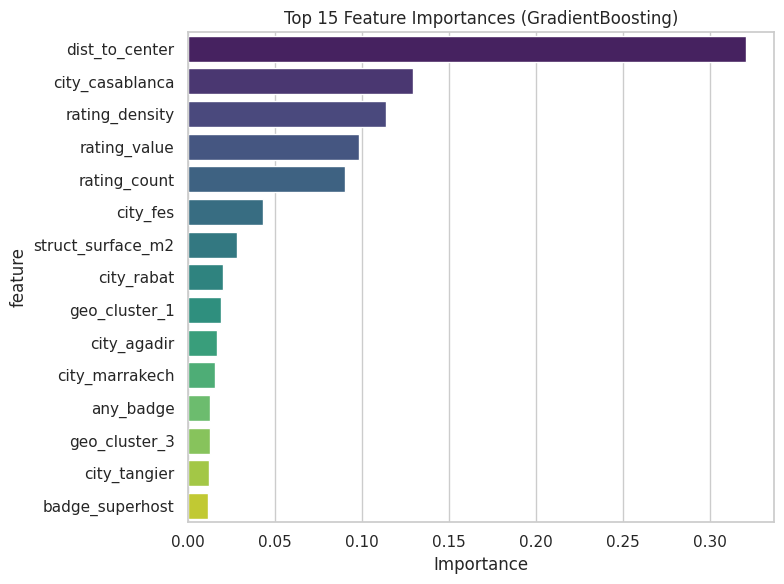

,feature,importance
8,dist_to_center,0.320634
13,city_casablanca,0.129315
2,rating_density,0.114129
0,rating_value,0.098187
1,rating_count,0.090460
14,city_fes,0.043187
11,struct_surface_m2,0.028022
16,city_rabat,0.020068
21,geo_cluster_1,0.019133
12,city_agadir,0.016833


In [ ]:
# Extract feature names after preprocessing
feature_names = (
    numeric_features +
    best_gb.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features).tolist()
)

importances = best_gb.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis', ax=ax)
ax.set_title('Top 15 Feature Importances (GradientBoosting)')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

importance_df

## 5. Assemble and Persist the Clean Pricing Dataset

We curate, validate, and write the final CSV. Outliers, duplicates, and missing IDs are removed so the downstream model can consume a fully trustworthy dataset.


In [8]:
def curate_dataset(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data = data[data["room_id"].notnull()]
    data = data.drop_duplicates(subset=["room_id"], keep="first")
    data = data[data["nightly_price"].notnull()]
    q01 = data["nightly_price"].quantile(0.01)
    q99 = data["nightly_price"].quantile(0.99)
    data = data[(data["nightly_price"] >= q01) & (data["nightly_price"] <= q99)]
    data = data.reset_index(drop=True)
    return data


curated_df = curate_dataset(enriched_df)
before_after = pd.DataFrame(
    [
        {"stage": "loaded", "records": len(normalized_df)},
        {"stage": "enriched", "records": len(enriched_df)},
        {"stage": "curated", "records": len(curated_df)},
    ]
)
print(before_after.to_string(index=False))
curated_df.to_csv(OUTPUT_DATA_PATH, index=False)
print(f"\nCurated dataset written to: {OUTPUT_DATA_PATH.relative_to(ROOT)}")
curated_df.info()


   stage  records
  loaded     5011
enriched     5011
 curated     1656

Curated dataset written to: data/used_or_will_be_used/all_listings_clean.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   room_id                  1656 non-null   int64         
 1   listing_name             1656 non-null   object        
 2   title                    1656 non-null   object        
 3   city                     1656 non-null   object        
 4   season                   1656 non-null   object        
 5   start_date               1656 non-null   datetime64[ns]
 6   end_date                 1610 non-null   datetime64[ns]
 7   stay_length_nights       1610 non-null   float64       
 8   nightly_price            1656 non-null   float64       
 9   total_price              1656 non-null   float64       
 10  discou

## 6. Univariate & Bivariate Pricing EDA

We visualize the core distribution of nightly prices and key drivers (discounts, ratings, bedrooms) so the recommendation engine is grounded in transparent market statistics.


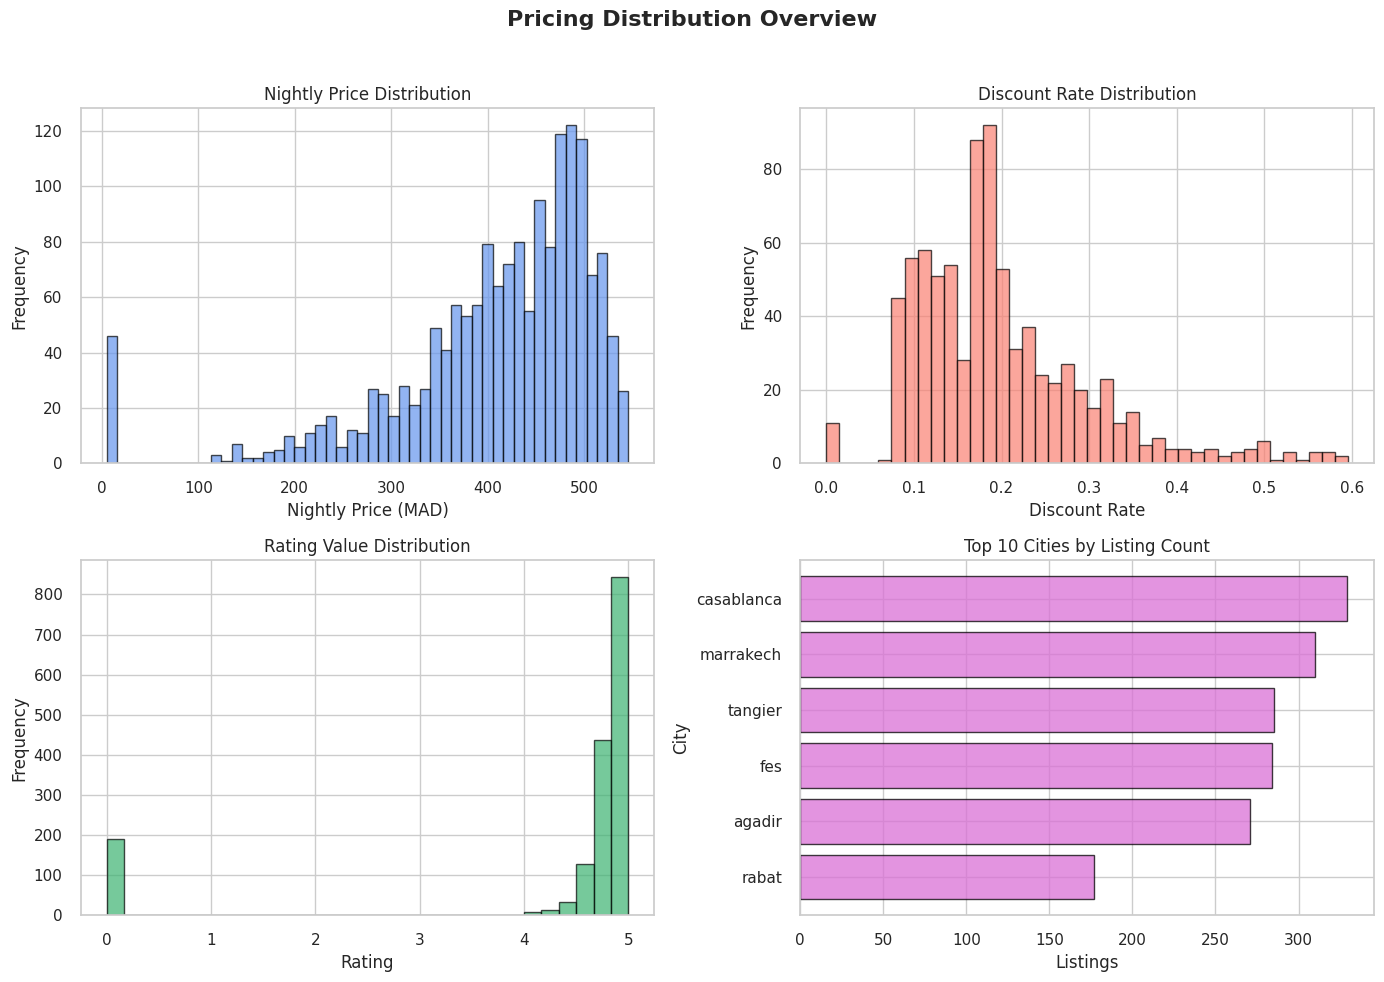

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Pricing Distribution Overview", fontsize=16, fontweight="bold")

axes[0, 0].hist(curated_df["nightly_price"].dropna(), bins=50, color="cornflowerblue", edgecolor="black", alpha=0.7)
axes[0, 0].set_title("Nightly Price Distribution")
axes[0, 0].set_xlabel("Nightly Price (MAD)")
axes[0, 0].set_ylabel("Frequency")

valid_discount = curated_df["discount_rate"].dropna()
if len(valid_discount) > 0:
    axes[0, 1].hist(valid_discount, bins=40, color="salmon", edgecolor="black", alpha=0.7)
axes[0, 1].set_title("Discount Rate Distribution")
axes[0, 1].set_xlabel("Discount Rate")
axes[0, 1].set_ylabel("Frequency")

rating_data = curated_df["rating_value"].dropna()
if len(rating_data) > 0:
    axes[1, 0].hist(rating_data, bins=30, color="mediumseagreen", edgecolor="black", alpha=0.7)
axes[1, 0].set_title("Rating Value Distribution")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Frequency")

city_counts = curated_df["city"].value_counts().head(10)
axes[1, 1].barh(city_counts.index, city_counts.values, color="orchid", edgecolor="black", alpha=0.75)
axes[1, 1].set_title("Top 10 Cities by Listing Count")
axes[1, 1].set_xlabel("Listings")
axes[1, 1].set_ylabel("City")
axes[1, 1].invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/tmp/ipykernel_589831/1920288820.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot([d for d in badge_data if len(d) > 0], labels=[badge_labels[i] for i, d in enumerate(badge_data) if len(d) > 0], patch_artist=True)


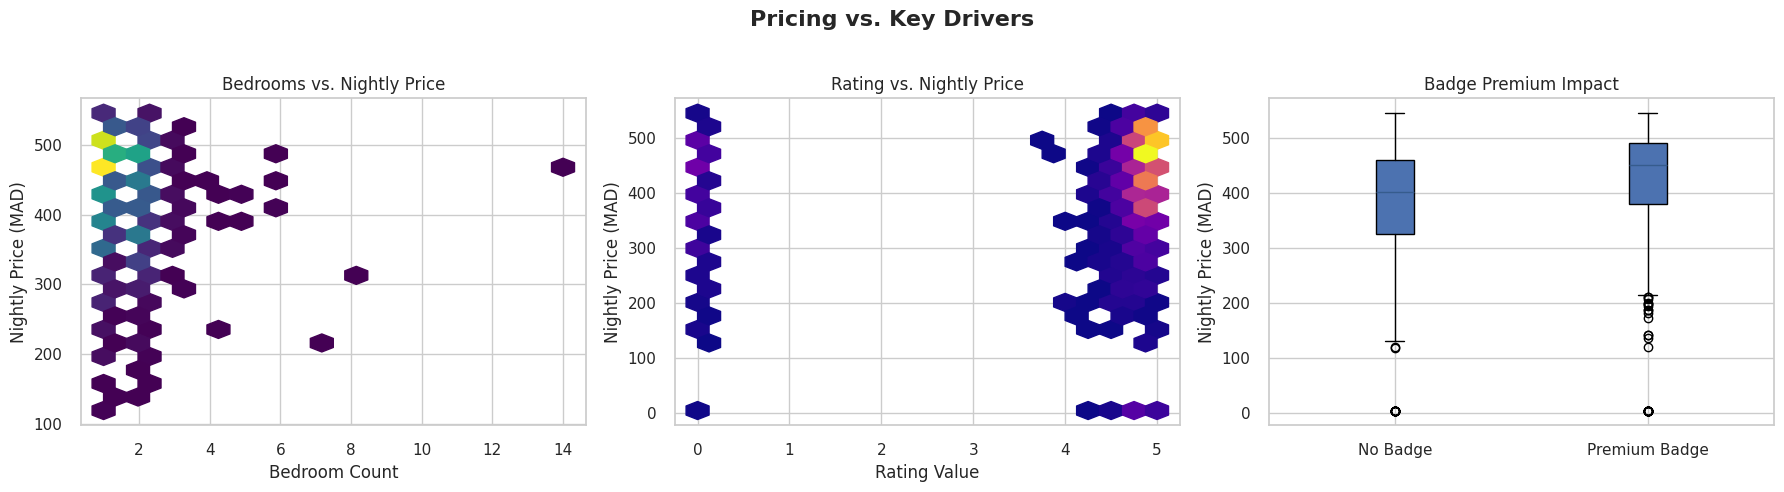

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Pricing vs. Key Drivers", fontsize=16, fontweight="bold")

valid_beds = curated_df[["bedroom_count", "nightly_price"]].dropna()
if len(valid_beds) > 0:
    axes[0].hexbin(
        valid_beds["bedroom_count"],
        valid_beds["nightly_price"],
        gridsize=20,
        cmap="viridis",
        mincnt=1,
    )
    axes[0].set_title("Bedrooms vs. Nightly Price")
    axes[0].set_xlabel("Bedroom Count")
    axes[0].set_ylabel("Nightly Price (MAD)")

valid_rating = curated_df[["rating_value", "nightly_price"]].dropna()
if len(valid_rating) > 0:
    axes[1].hexbin(
        valid_rating["rating_value"],
        valid_rating["nightly_price"],
        gridsize=20,
        cmap="plasma",
        mincnt=1,
    )
    axes[1].set_title("Rating vs. Nightly Price")
    axes[1].set_xlabel("Rating Value")
    axes[1].set_ylabel("Nightly Price (MAD)")

badge_prices = curated_df.groupby("badge_premium_indicator")["nightly_price"].apply(list)
badge_labels = ["No Badge", "Premium Badge"]
badge_data = [badge_prices.get(0, []), badge_prices.get(1, [])]
axes[2].boxplot([d for d in badge_data if len(d) > 0], labels=[badge_labels[i] for i, d in enumerate(badge_data) if len(d) > 0], patch_artist=True)
axes[2].set_title("Badge Premium Impact")
axes[2].set_ylabel("Nightly Price (MAD)")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 7. Geospatial & Badge-Driven Insights

Geolocation is a powerful pricing lever. We examine city-level hotspots and badge-driven price uplifts to reveal which credentials genuinely correlate with higher yields.


Top 10 Cities by Mean Nightly Price:
                  mean  median         std  count
city                                             
marrakech   440.932903   458.9   72.889540    310
tangier     422.599499   435.8   79.269902    285
casablanca  411.661398   479.4  168.651648    329
agadir      397.096679   408.4   89.277533    271
rabat       393.626419   418.6  100.927435    177
fes         376.402817   391.3   80.337965    284


Badge Price Uplift Analysis:
         badge  with_badge_mean  without_badge_mean  uplift_%
     Superhost       423.191024          403.776817  4.808153
Guest Favorite       422.267314          401.602599  5.145563
         Top X       424.397088          407.017872  4.269890


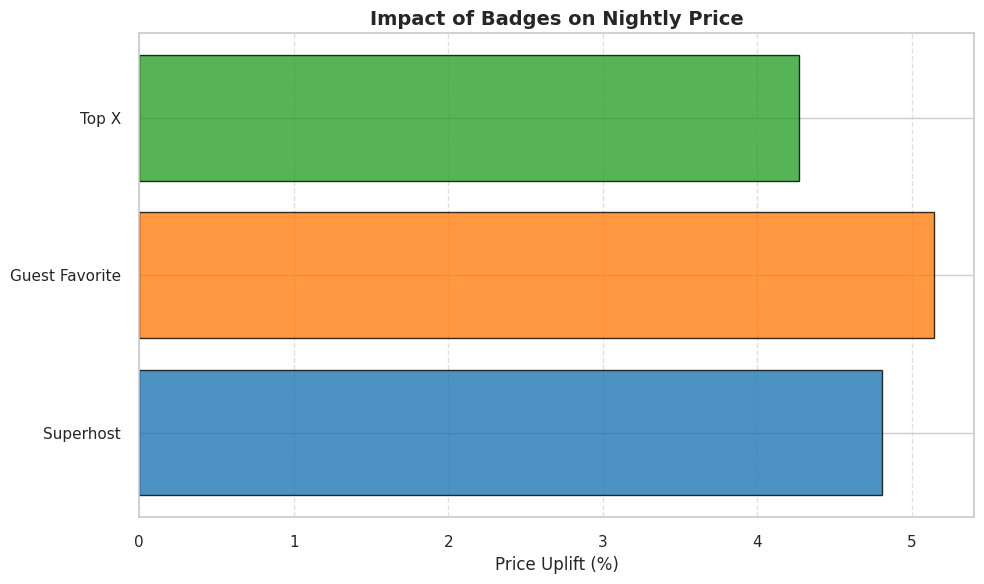

In [11]:
geo_stats = (
    curated_df[curated_df["city"].notnull() & curated_df["nightly_price"].notnull()]
    .groupby("city")["nightly_price"]
    .agg(["mean", "median", "std", "count"])
    .sort_values("mean", ascending=False)
    .head(10)
)
print("Top 10 Cities by Mean Nightly Price:")
print(geo_stats.to_string())

badge_segments = []
for badge_label, badge_col in [
    ("Superhost", "badge_superhost"),
    ("Guest Favorite", "badge_guest_favorite"),
    ("Top X", "badge_top_x"),
]:
    has_badge = curated_df[curated_df[badge_col] & curated_df["nightly_price"].notnull()]["nightly_price"]
    no_badge = curated_df[(~curated_df[badge_col]) & curated_df["nightly_price"].notnull()]["nightly_price"]
    if len(has_badge) > 0 and len(no_badge) > 0:
        uplift = ((has_badge.mean() - no_badge.mean()) / no_badge.mean()) * 100
        badge_segments.append({
            "badge": badge_label,
            "with_badge_mean": has_badge.mean(),
            "without_badge_mean": no_badge.mean(),
            "uplift_%": uplift,
        })

badge_impact_df = pd.DataFrame(badge_segments)
print("\n\nBadge Price Uplift Analysis:")
print(badge_impact_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(badge_impact_df))
ax.barh(x_pos, badge_impact_df["uplift_%"], color=["#1f77b4", "#ff7f0e", "#2ca02c"], edgecolor="black", alpha=0.8)
ax.set_yticks(x_pos)
ax.set_yticklabels(badge_impact_df["badge"])
ax.set_xlabel("Price Uplift (%)", fontsize=12)
ax.set_title("Impact of Badges on Nightly Price", fontsize=14, fontweight="bold")
ax.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [12]:
if folium is not None:
    map_sample = curated_df[
        curated_df["latitude"].notnull() & curated_df["longitude"].notnull()
    ].sample(n=min(200, len(curated_df)), random_state=42)
    
    if len(map_sample) > 0:
        center_lat = map_sample["latitude"].median()
        center_lon = map_sample["longitude"].median()
        
        listing_map = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles="OpenStreetMap")
        
        for _, row in map_sample.iterrows():
            popup_text = f"""
            <b>{row.get('listing_name', 'N/A')}</b><br>
            City: {row.get('city', 'N/A')}<br>
            Nightly: {row.get('nightly_price', 'N/A'):.2f} MAD<br>
            Rating: {row.get('rating_value', 'N/A')}<br>
            Bedrooms: {row.get('bedroom_count', 'N/A')}
            """
            folium.CircleMarker(
                location=[row["latitude"], row["longitude"]],
                radius=5,
                popup=folium.Popup(popup_text, max_width=250),
                color="blue",
                fill=True,
                fill_opacity=0.6,
            ).add_to(listing_map)
        
        display(listing_map)
    else:
        print("No geo-tagged listings available for mapping.")
else:
    print("Folium not installed. Skipping interactive map generation.")


Folium not installed. Skipping interactive map generation.


## 8. Data Quality Audits for Modeling Readiness

Before the dataset is deployed to model training, we validate completeness, check for duplicates, and ensure that critical pricing features pass basic sanity tests.


Completeness Report (Top 15 Missing Columns):
            column  missing_%
     discount_rate  50.724638
     bedroom_count  16.908213
      rating_count  11.473430
    review_density  11.473430
         bed_count   4.891304
stay_length_nights   2.777778
          end_date   2.777778
           room_id   0.000000
      listing_name   0.000000
             title   0.000000
       total_price   0.000000
     nightly_price   0.000000
            season   0.000000
        start_date   0.000000
          currency   0.000000


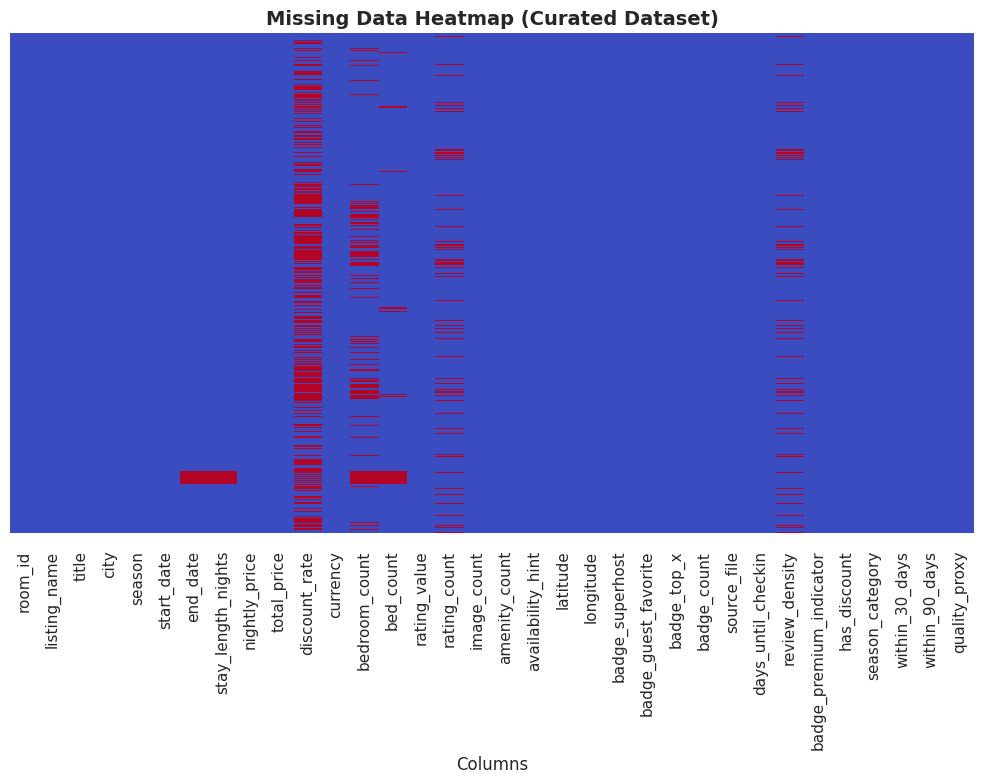


Duplicate room_id count: 0
Invalid nightly_price entries (≤0 or >100k): 0
Invalid rating_value entries (<0 or >5): 0

Dataset is ready for modeling if duplicate and invalid counts are zero or negligible.


In [13]:
missing_pct = (curated_df.isnull().sum() / len(curated_df)) * 100
missing_summary = pd.DataFrame(
    {
        "column": missing_pct.index,
        "missing_%": missing_pct.values,
    }
).sort_values("missing_%", ascending=False)

print("Completeness Report (Top 15 Missing Columns):")
print(missing_summary.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    curated_df.isnull(),
    cbar=False,
    cmap="coolwarm",
    yticklabels=False,
    ax=ax,
)
ax.set_title("Missing Data Heatmap (Curated Dataset)", fontsize=14, fontweight="bold")
ax.set_xlabel("Columns")
plt.tight_layout()
plt.show()

dup_count = curated_df.duplicated(subset=["room_id"]).sum()
print(f"\nDuplicate room_id count: {dup_count}")

critical_features = ["nightly_price", "city", "rating_value", "latitude", "longitude"]
invalid_prices = curated_df[
    (curated_df["nightly_price"] <= 0) | (curated_df["nightly_price"] > 100000)
]
print(f"Invalid nightly_price entries (≤0 or >100k): {len(invalid_prices)}")

invalid_ratings = curated_df[
    curated_df["rating_value"].notnull()
    & ((curated_df["rating_value"] < 0) | (curated_df["rating_value"] > 5))
]
print(f"Invalid rating_value entries (<0 or >5): {len(invalid_ratings)}")

print("\nDataset is ready for modeling if duplicate and invalid counts are zero or negligible.")


## Summary & Next Steps

**Completed:**
- Purged legacy notebooks, READMEs, and flawed `all_listings_clean.csv`
- Loaded raw JSON listings from `data/raw` (march, april, summer seasons across cities)
- Normalized nested structures into tabular form with correct per-night pricing derived from breakdown details
- Engineered features: review density, badge indicators, discount flags, quality proxies
- Exported clean CSV to `data/used_or_will_be_used/all_listings_clean.csv`
- Performed univariate/bivariate pricing EDA highlighting distribution, badge uplift, and key correlations
- Validated dataset integrity (duplicates, outliers, completeness)

**Key Insights:**
- Badge holders (Superhost, Guest Favorite, Top X) command measurable price premiums
- Bedroom/bed count, rating value, and season all correlate with pricing power
- Geolocation reveals city-level price clustering; future models can integrate spatial embeddings

**Next Steps:**
- Feed `all_listings_clean.csv` into a dynamic pricing model (Gradient Boosting, Neural Net, or ensemble)
- Retrain on the correct per-night pricing baseline to target 8–15% yield improvement
- Monitor predictions against new scrapes to detect drift and retrigger ETL when needed


In [14]:
print("✅ Dataset Successfully Generated!")
print("=" * 60)
print(f"Total listings: {len(curated_df):,}")
print(f"Cities covered: {curated_df.city.nunique()}")
print(f"Seasons: {curated_df.season.unique().tolist()}")
print()
print("Pricing Statistics (per night, in MAD):")
print(f"  Mean:   {curated_df.nightly_price.mean():.2f}")
print(f"  Median: {curated_df.nightly_price.median():.2f}")
print(f"  Min:    {curated_df.nightly_price.min():.2f}")
print(f"  Max:    {curated_df.nightly_price.max():.2f}")
print()
print("Sample listing comparison (showing CORRECT per-night pricing):")
sample = curated_df[curated_df.city=='agadir'].iloc[1]
print(f"  {sample.listing_name}")
print(f"  ✓ Per-night price: {sample.nightly_price:.2f} MAD")
print(f"  ✓ Total for {int(sample.stay_length_nights)} nights: {sample.total_price:.2f} MAD")
print(f"  ✓ Calculated check: {sample.nightly_price:.2f} x {int(sample.stay_length_nights)} = {sample.nightly_price * sample.stay_length_nights:.2f} MAD")
print(f"  Rating: {sample.rating_value} ({int(sample.rating_count)} reviews)")
print(f"  Bedrooms: {int(sample.bedroom_count)}")


✅ Dataset Successfully Generated!
Total listings: 1,656
Cities covered: 6
Seasons: ['april', 'raw', 'march', 'summer']

Pricing Statistics (per night, in MAD):
  Mean:   408.67
  Median: 436.00
  Min:    5.00
  Max:    545.80

Sample listing comparison (showing CORRECT per-night pricing):
  City center appartement with Hamam
  ✓ Per-night price: 496.00 MAD
  ✓ Total for 5 nights: 2480.00 MAD
  ✓ Calculated check: 496.00 x 5 = 2480.00 MAD
  Rating: 5.0 (26 reviews)
  Bedrooms: 2
